In [1]:
!pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt

df = pd.read_csv('/content/diabetes.csv')

x = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train.ravel())


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=16, max_value=128, step=16),
                    activation=hp.Choice('activation1', ['relu', 'tanh']),
                    input_shape=(X_train_scaled.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                        activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

tuner.search(X_train_res, y_train_res, epochs=100, validation_split=0.2, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
_, accuracy_enhanced = best_model.evaluate(X_test_scaled, y_test)
print(f"Enhanced Neural Network Accuracy: {accuracy_enhanced}")

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


After OverSampling, the shape of train_X: (802, 8)
After OverSampling, the shape of train_y: (802,)
After OverSampling, counts of label '1': 401
After OverSampling, counts of label '0': 401
Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3430 - loss: 0.7035  
Enhanced Neural Network Accuracy: 0.3571428656578064
Best Hyperparameters: {'units1': 64, 'activation1': 'tanh', 'num_layers': 2, 'units_0': 16, 'activation_0': 'relu', 'optimizer': 'sgd', 'units_1': 128, 'activation_1': 'relu', 'units_2': 128, 'activation_2': 'relu', 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}


Shape of X_train_res: (802, 8)
Shape of y_train_res: (802,)
New shape of X_train_res: (802, 8)
New shape of y_train_res: (802,)
Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7394 - loss: 0.5199 - val_accuracy: 0.4286 - val_loss: 0.7731
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7209 - loss: 0.5322 - val_accuracy: 0.3230 - val_loss: 0.9157
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6989 - loss: 0.5465 - val_accuracy: 0.5217 - val_loss: 0.6903
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7175 - loss: 0.5281 - val_accuracy: 0.6335 - val_loss: 0.6174
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7388 - loss: 0.5346 - val_accuracy: 0.4348 - val_loss: 0.7752
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7311 - loss: 0.5244 - val_accuracy: 0.7143 - val_loss: 0.5744
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7277 - loss: 0.5379 - val_accuracy: 0.4534 - 

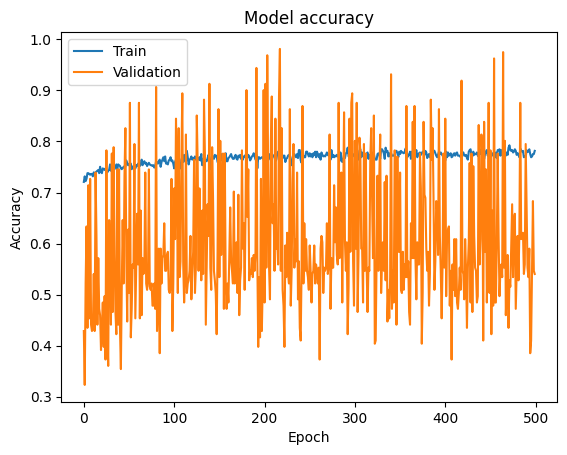

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Import TensorFlow

print("Shape of X_train_res:", X_train_res.shape)
print("Shape of y_train_res:", y_train_res.shape)

y_train_res = y_train_res.ravel()

if isinstance(X_train_res, tf.Tensor):
    X_train_res = X_train_res.numpy()
if isinstance(y_train_res, tf.Tensor):
    y_train_res = y_train_res.numpy()

print("New shape of X_train_res:", X_train_res.shape)
print("New shape of y_train_res:", y_train_res.shape)


history = best_model.fit(X_train_res.astype(np.float32),  # Ensure float32 type
                         y_train_res.astype(np.float32),  # Ensure float32 type
                         epochs=500,
                         validation_split=0.2,
                         verbose=1)



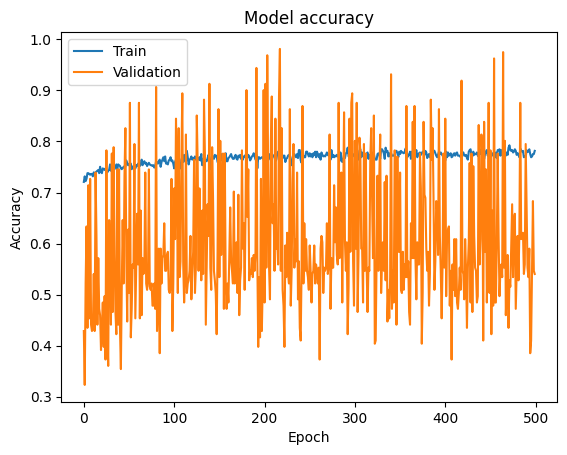

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
max_val_acc_index = np.argmax(history.history['val_accuracy'])
epoch_num = max_val_acc_index + 1
print(f"Epoch with maximum validation accuracy: {epoch_num}")


Epoch with maximum validation accuracy: 218


In [22]:
epoch_218_weights = best_model.get_weights()


In [23]:
best_model.set_weights(epoch_218_weights)
_, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f"Accuracy at epoch 218: {accuracy}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7159 - loss: 0.5110 
Accuracy at epoch 218: 0.7532467246055603


In [13]:
max_accuracy = max(history.history['val_accuracy'])
print("Maximum Accuracy:", max_accuracy)

Maximum Accuracy: 0.9813664555549622


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
y_pred = best_model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_binary))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.7532467532467533
